In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import sklearn as sk


# Import the Data

In [2]:
df = pd.read_csv("sensor.csv")
df.drop(columns="Unnamed: 0", inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df["timestamp"] = pd.to_datetime(df["timestamp"])
Elapsed_Time = df["timestamp"] - df["timestamp"][0]
df.insert(1, "Elapsed Time", Elapsed_Time)
df["Elapsed Time"] = df["Elapsed Time"].dt.total_seconds()
df.fillna(method='ffill', inplace=True)


C:\Users\Jay\AppData\Local\Temp\ipykernel_18680\313618335.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [3]:
df.head()

,timestamp,Elapsed Time,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,0.0,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,60.0,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,120.0,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,180.0,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,240.0,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


## Investigate the Data 

Text(0.5, 1.0, 'Classification Clases for Target Variable (Machine Status)')

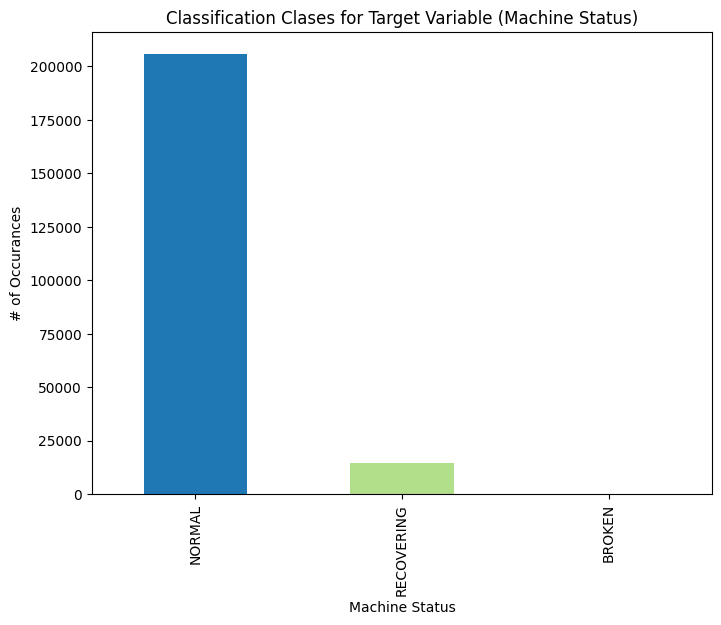

In [4]:
# Lets look at class inbalance first, namely with the variable in question, machine_status
plt.figure(figsize=(8, 6))
df["machine_status"].value_counts().plot(kind='bar', color=plt.cm.Paired([1,2,3]))
plt.xlabel("Machine Status")
plt.ylabel("# of Occurances")
plt.title("Classification Clases for Target Variable (Machine Status)")

### There's a clear class inbalance. Important to note when data is broken up in the future

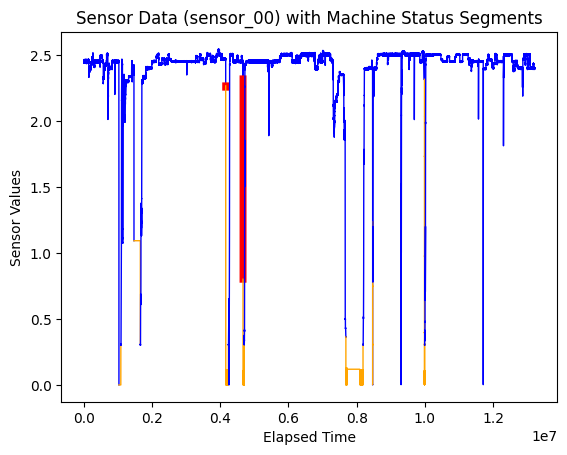

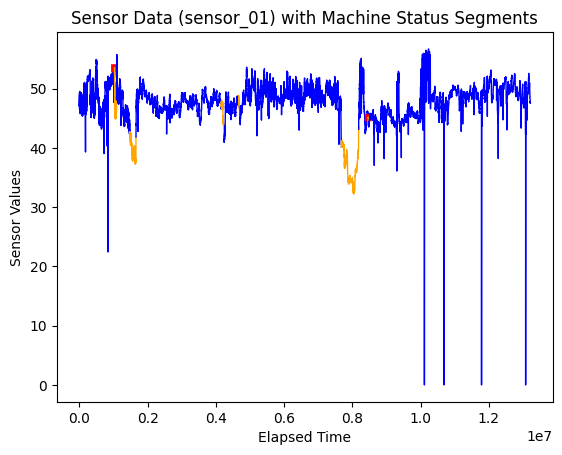

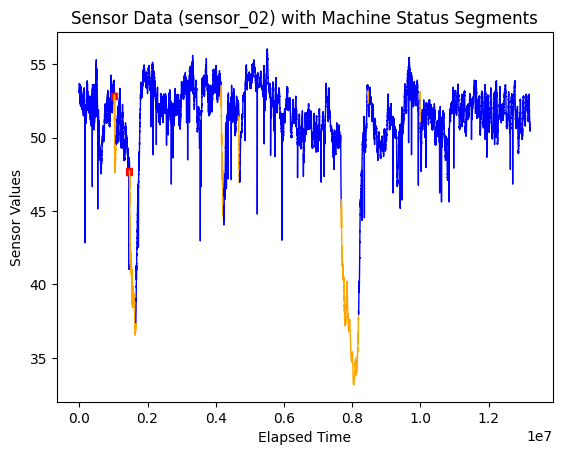

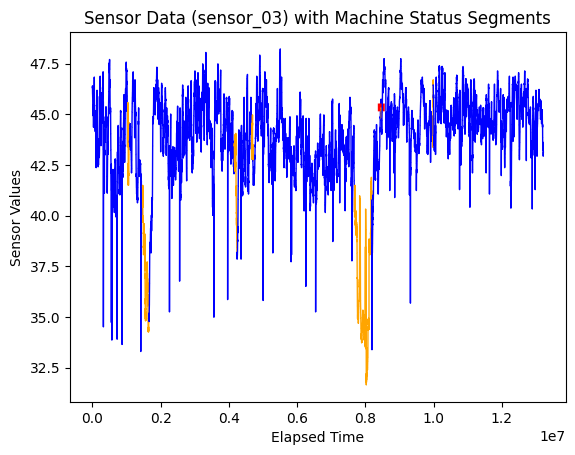

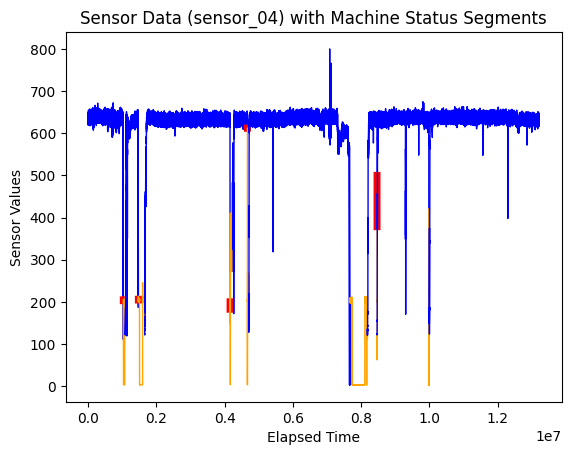

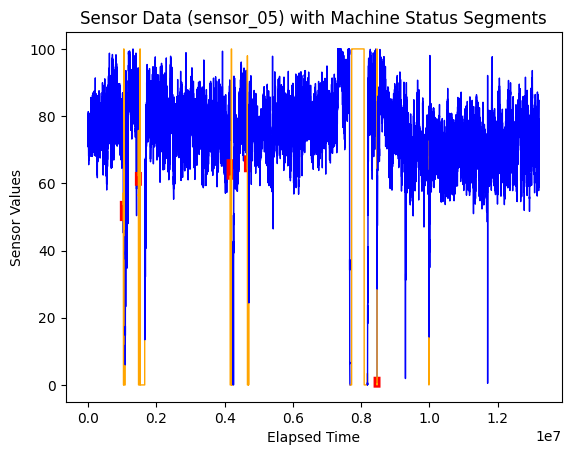

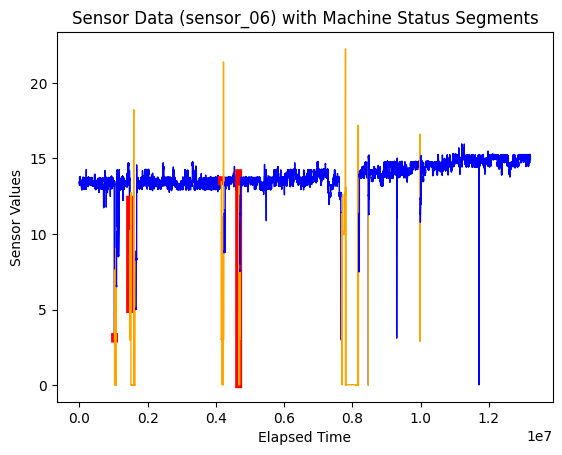

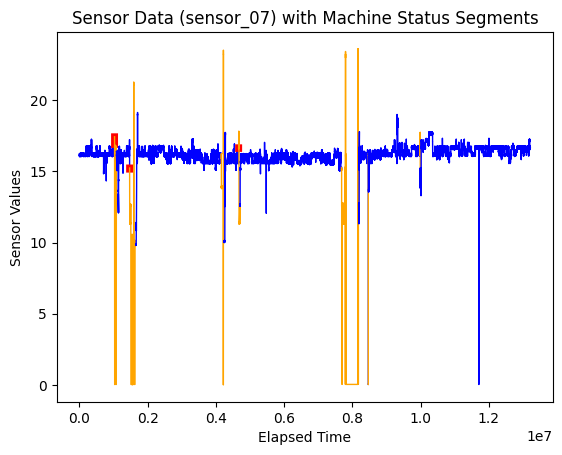

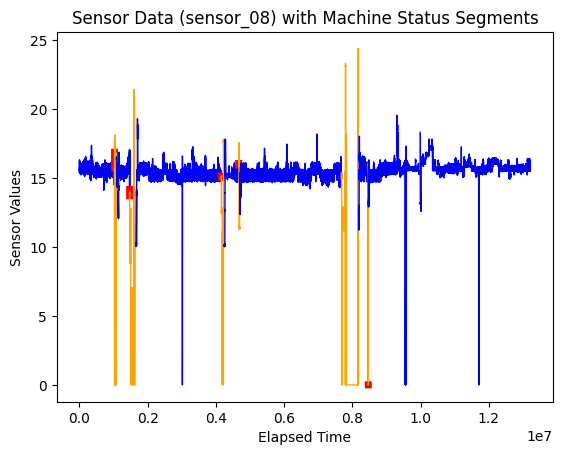

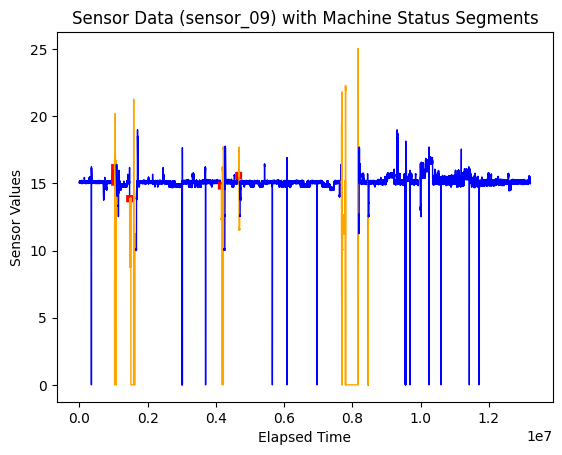

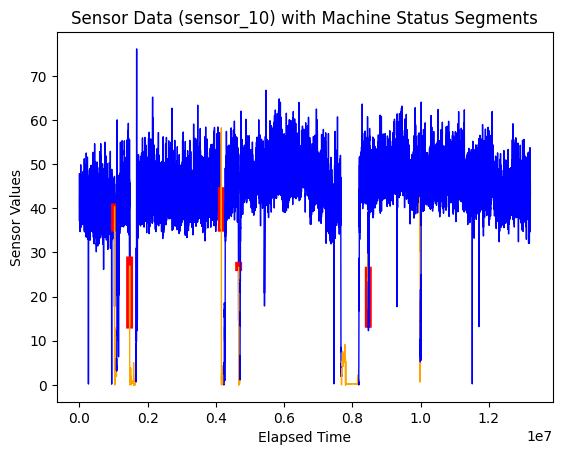

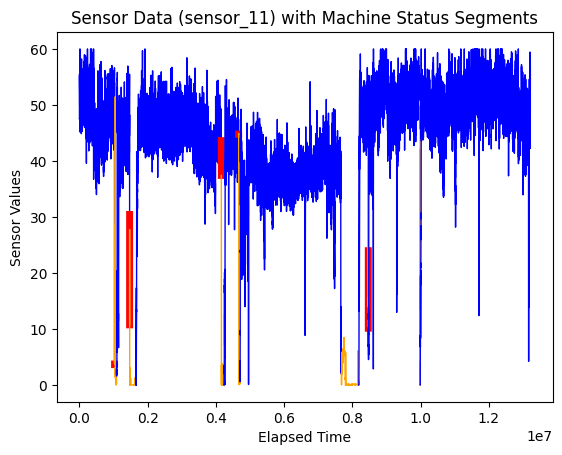

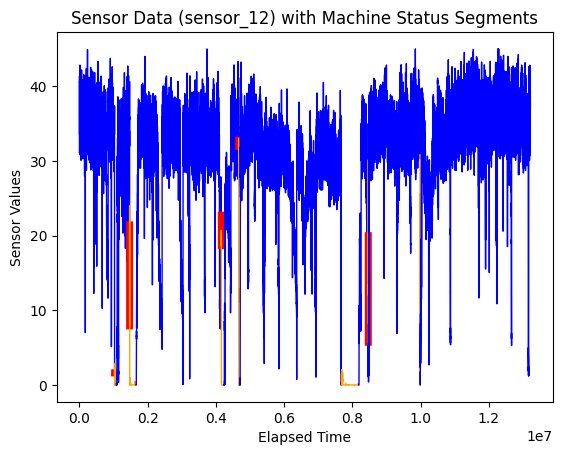

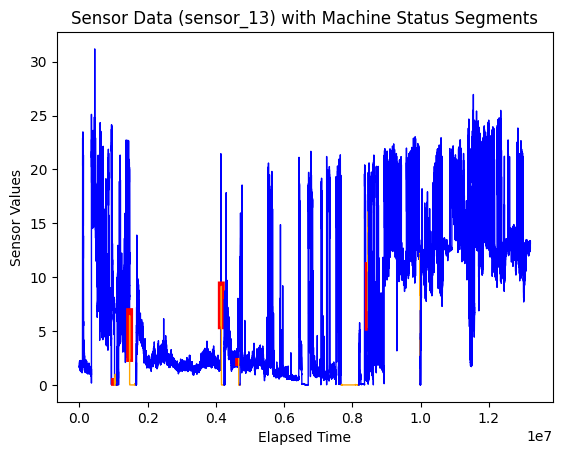

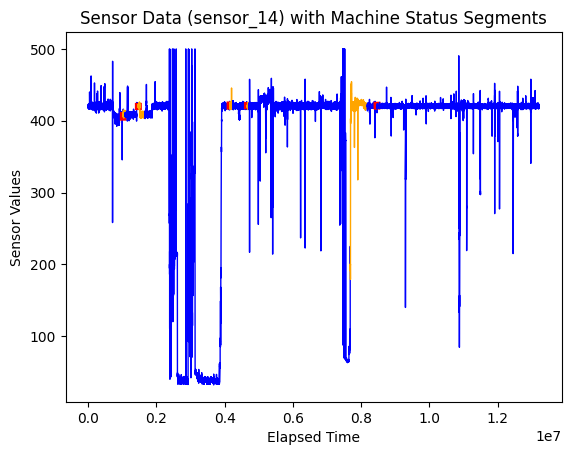

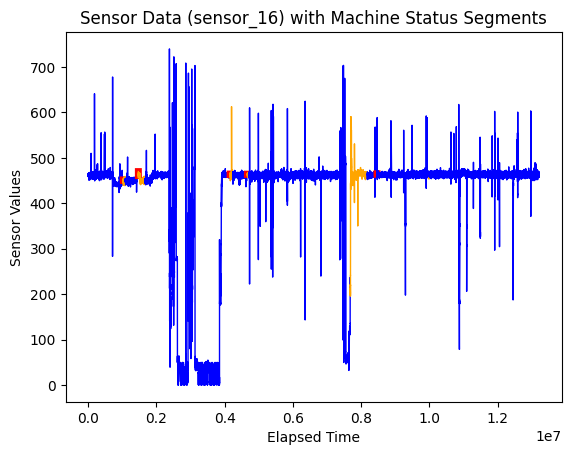

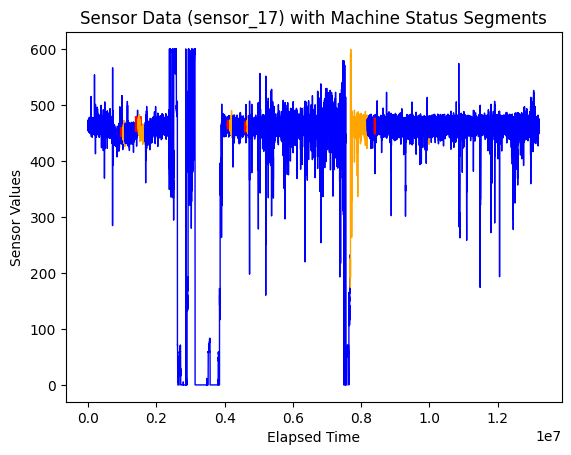

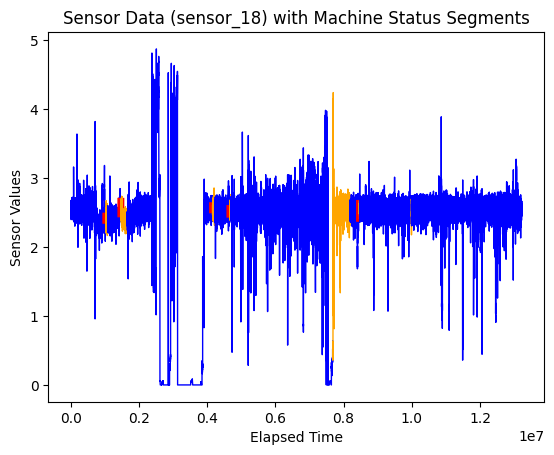

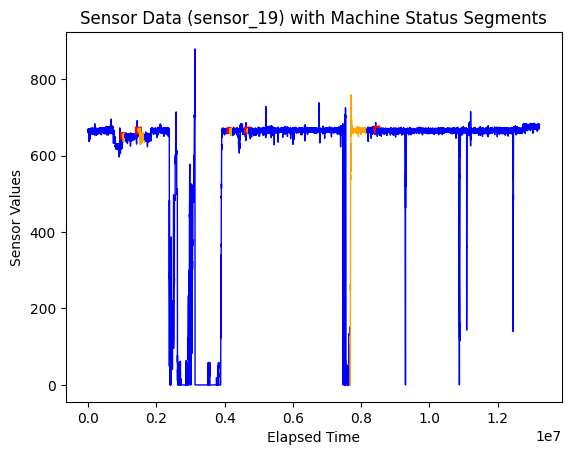

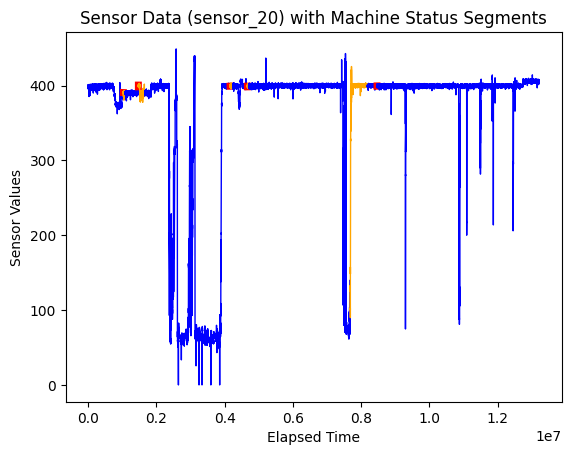

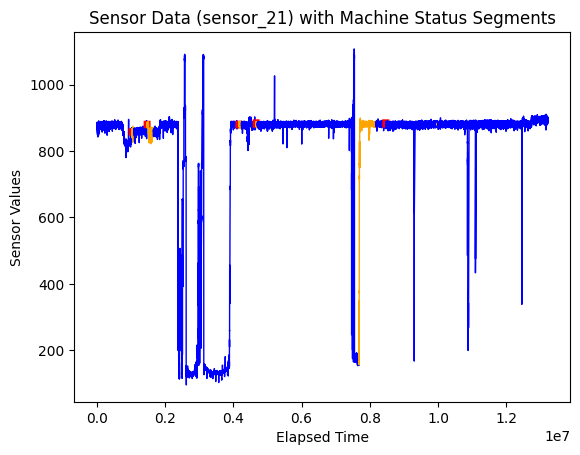

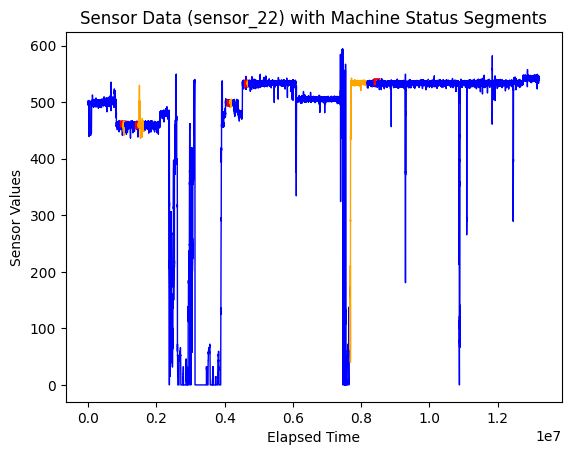

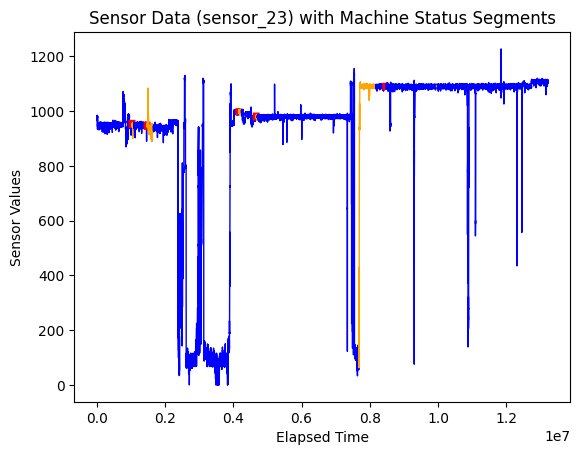

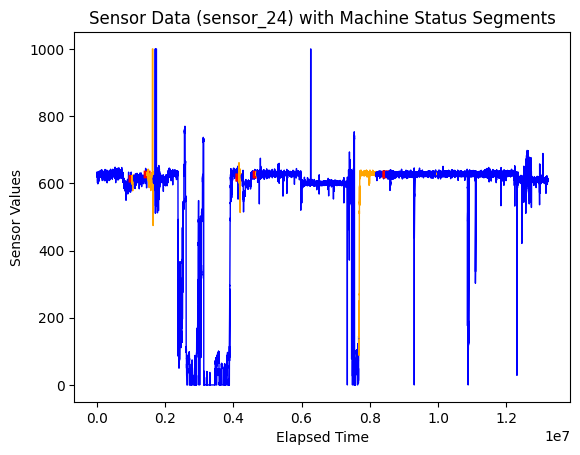

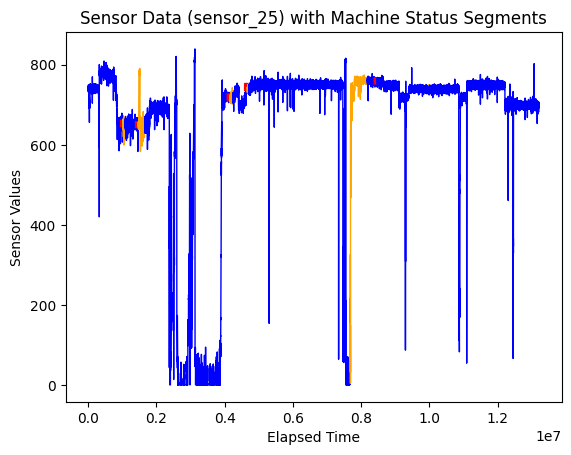

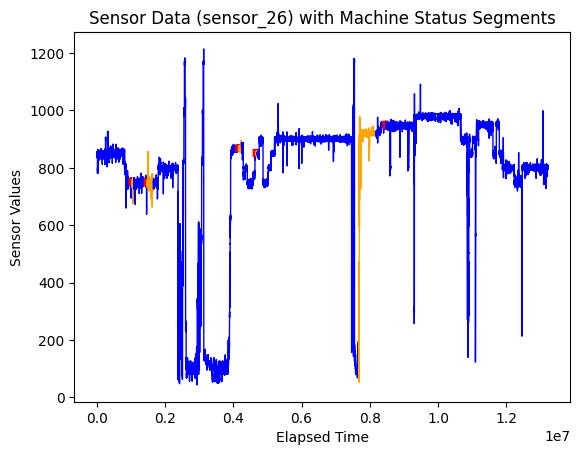

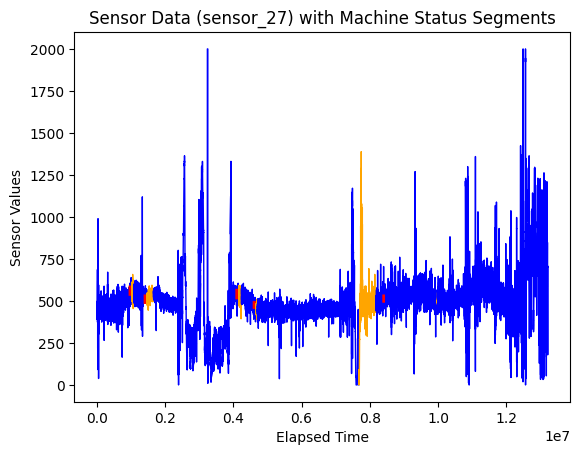

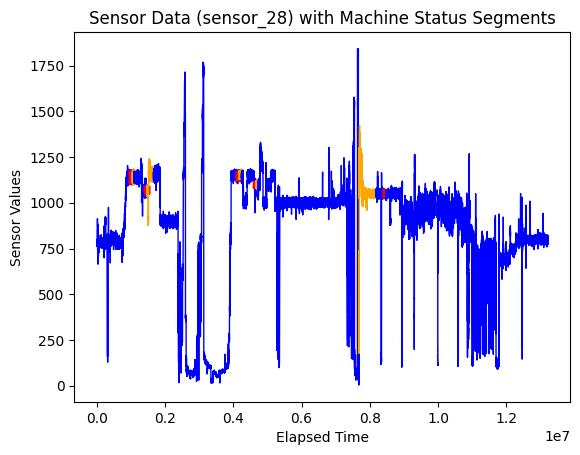

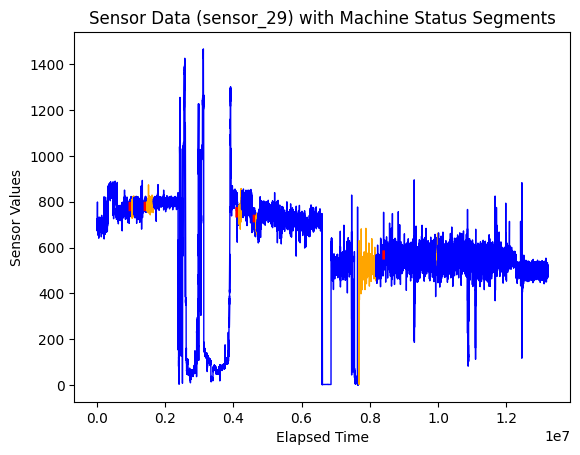

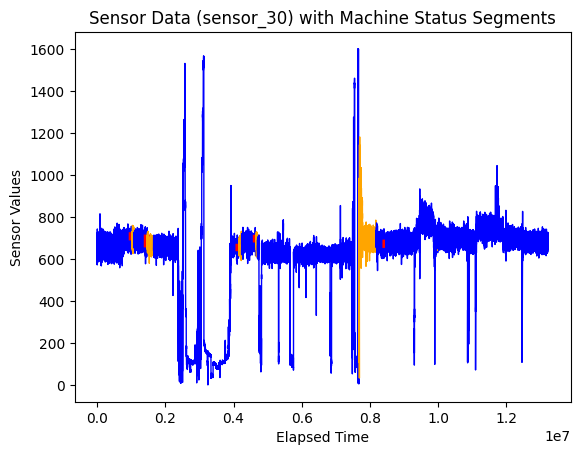

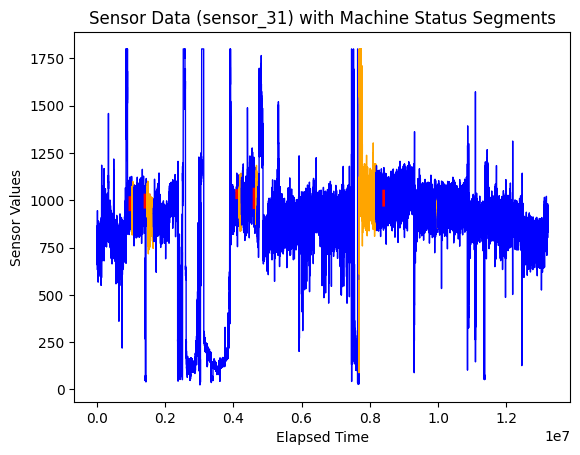

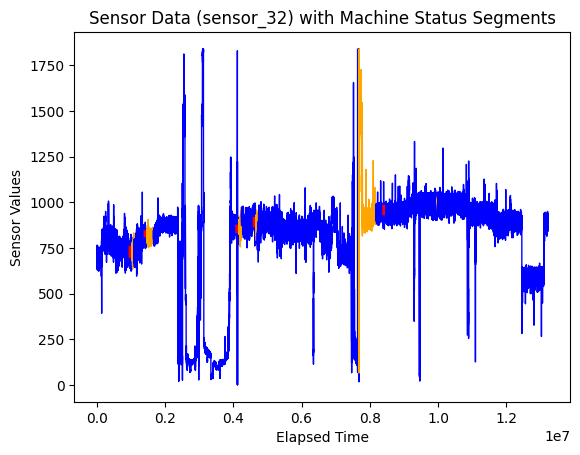

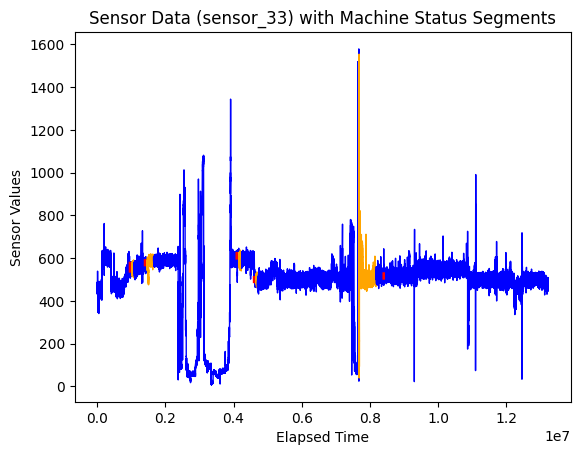

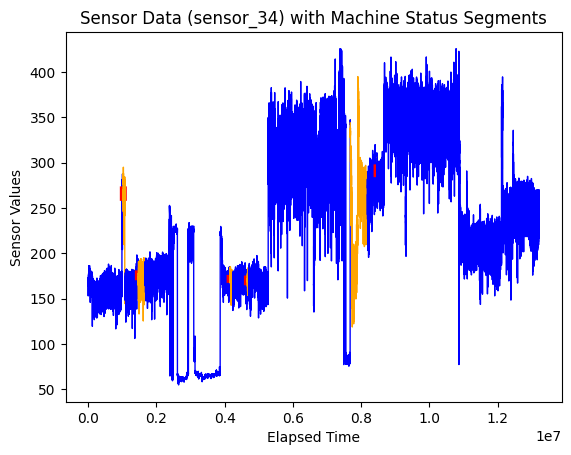

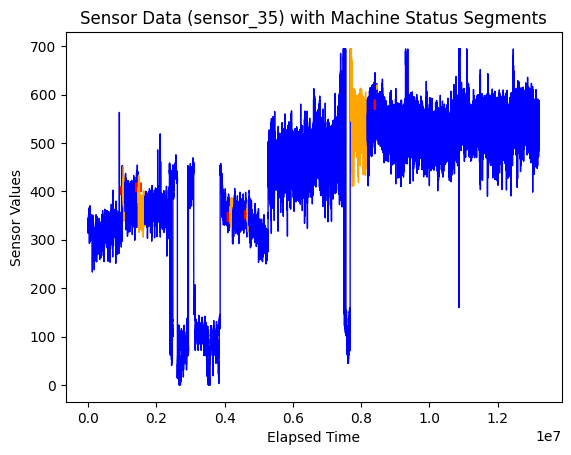

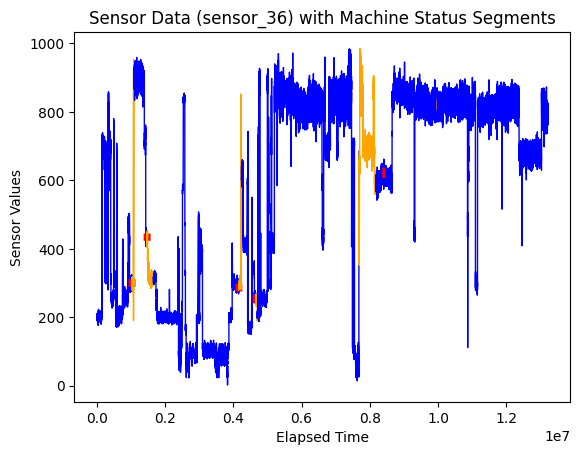

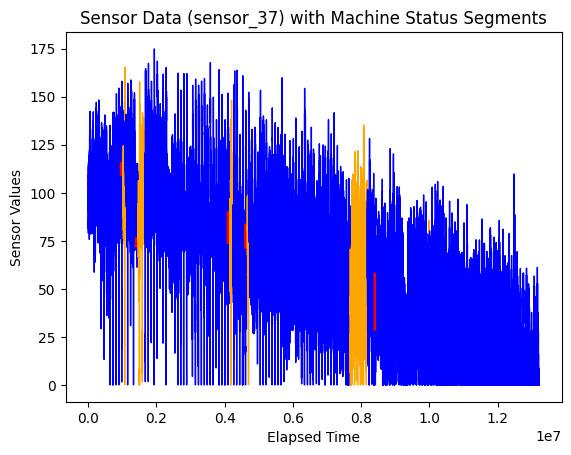

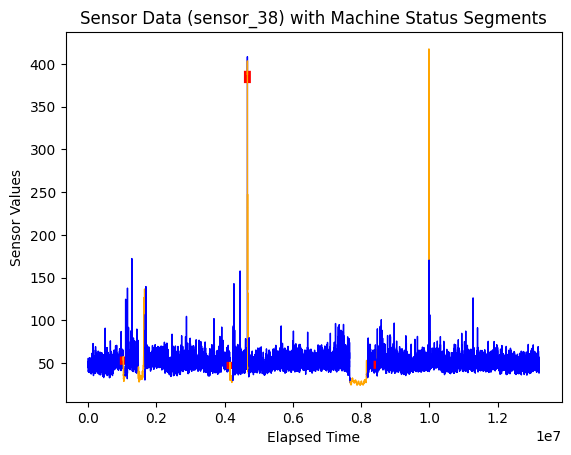

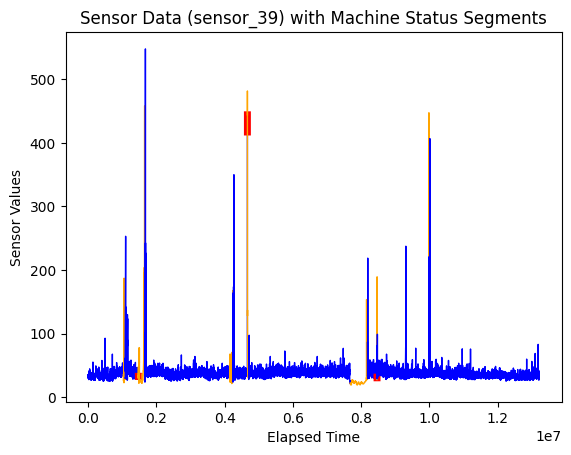

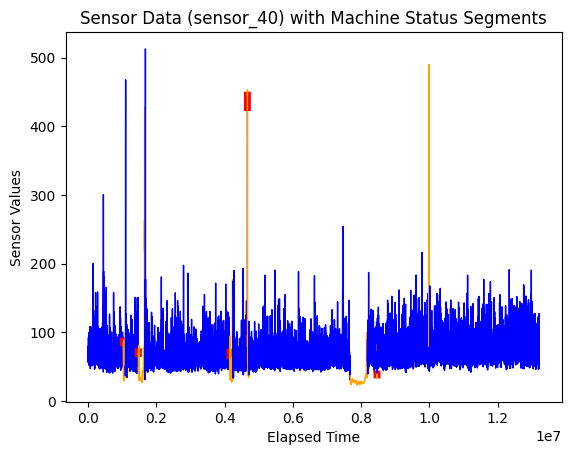

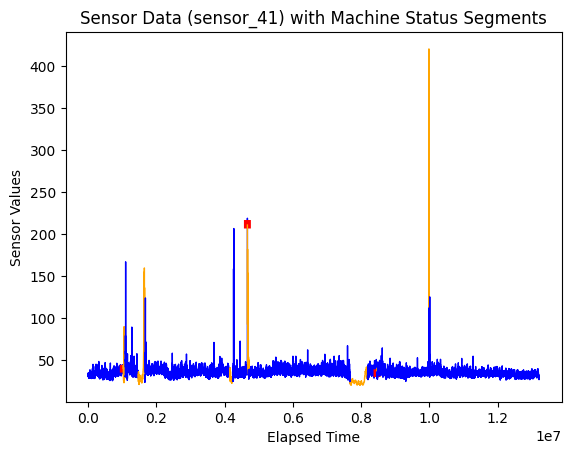

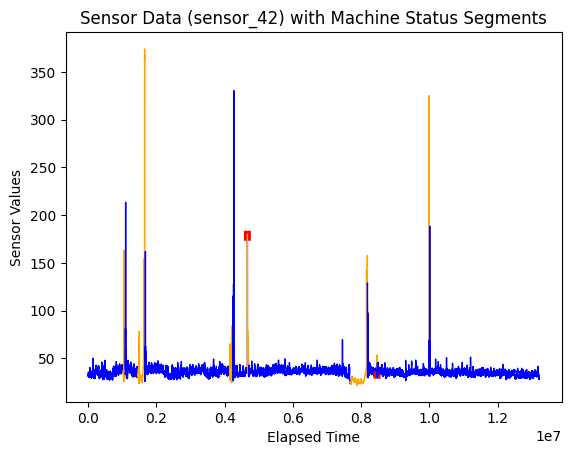

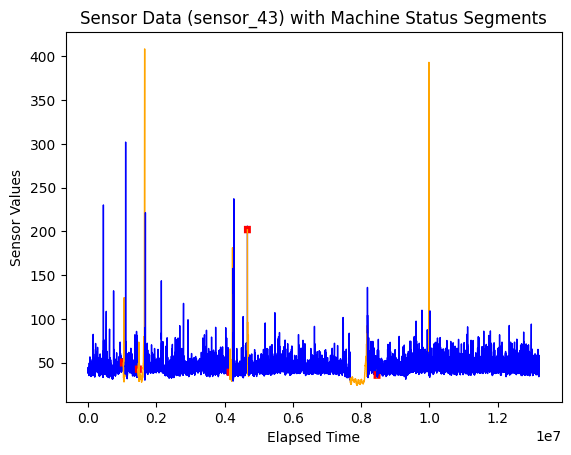

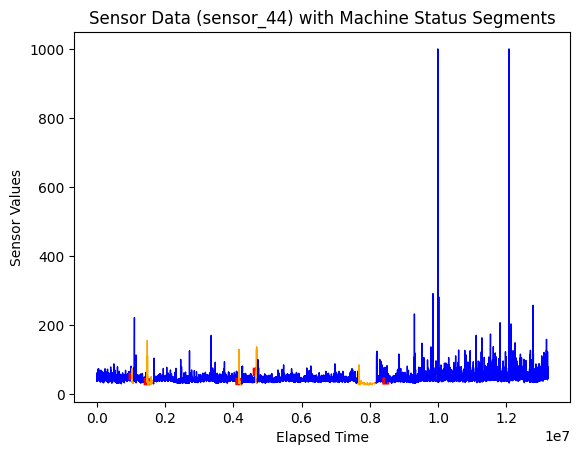

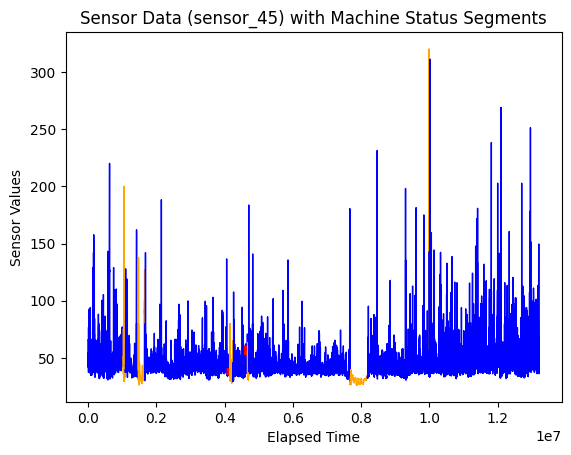

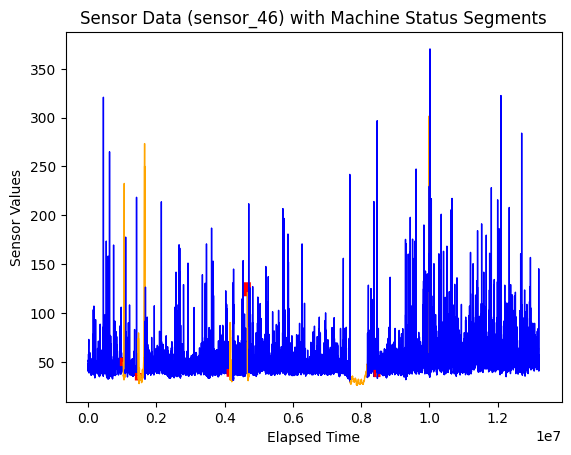

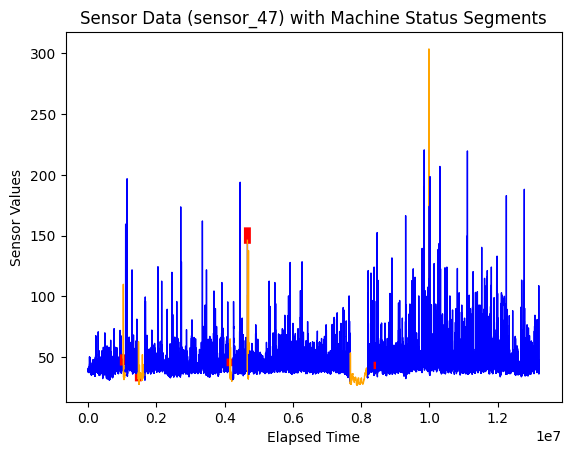

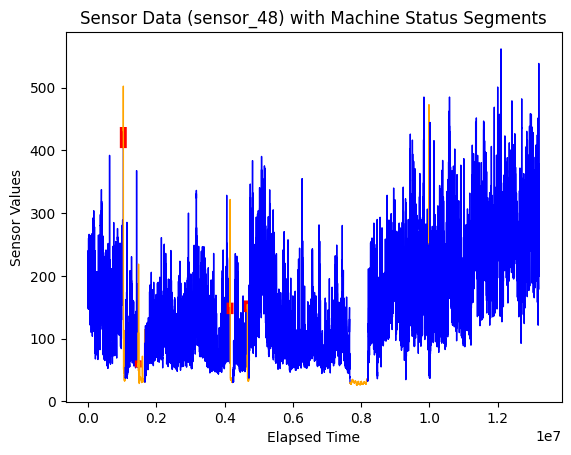

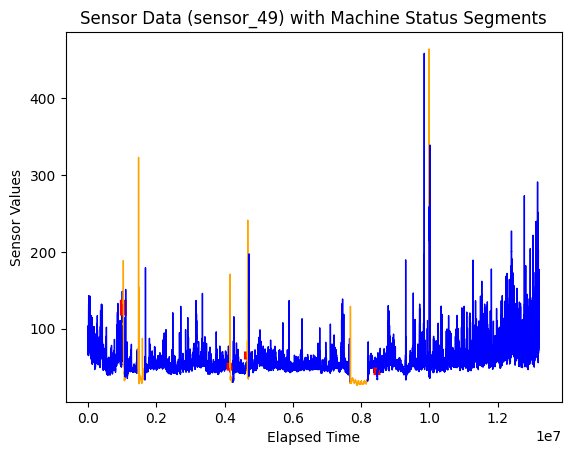

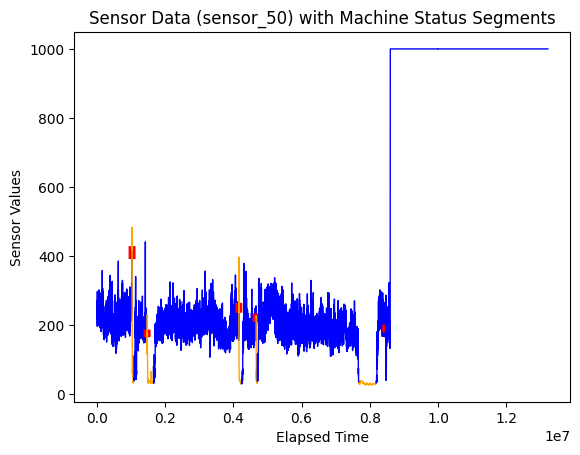

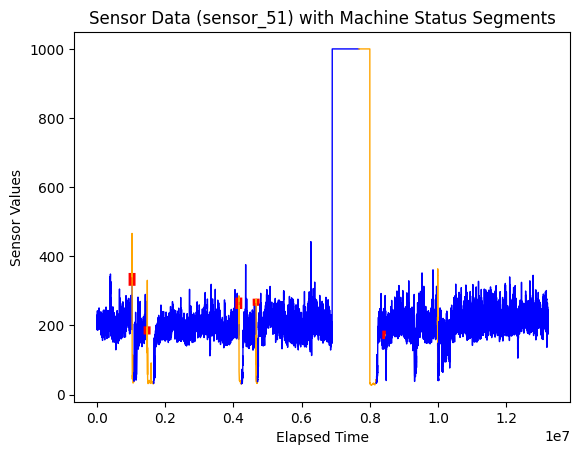

In [5]:
# Let's investigate when the failure occurs. Maybe we can plot the sensors a different colour 
# when it's down, its recovering, and when its function as it should
color_map = {
    "NORMAL"    : "blue",
    "RECOVERING": "orange",
    "BROKEN"    : "red"
}
for col in df.columns:
    if col not in ["Elapsed Time", "machine_status", "timestamp"]:
        last_status = None
        x_vals, y_vals = [], []
    else:
         continue
    for i in range(len(df)):
            current_status = df["machine_status"].iloc[i]
            
            # Append current data points
            x_vals.append(df["Elapsed Time"].iloc[i])
            y_vals.append(df[col].iloc[i])
            
            # If the status changes or this is the last point, plot the segment
            if current_status != last_status or i == len(df) - 1:
                if x_vals and y_vals:
                    line_width = 5 if last_status == "BROKEN" else 1
                    plt.plot(x_vals, y_vals, color=color_map.get(last_status, "gray"),  linewidth=line_width, label=last_status if last_status else "Unknown")
                
                # Reset for new segment
                x_vals, y_vals = [df["Elapsed Time"].iloc[i]], [df[col].iloc[i]]
            
            last_status = current_status
            
    # Add legend for the first sensor only
    plt.legend(loc="best") if col == df.columns[0] else None
    # Configure plot labels and title
    plt.xlabel("Elapsed Time")
    plt.ylabel("Sensor Values")
    plt.title(f"Sensor Data ({col}) with Machine Status Segments")
    plt.show()


# Separate into target and features

In [11]:
# Target is the machine status
target_variable = df["machine_status"]
# Features are the sensors
features = df.filter(like="sensor")

#scale target variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(features, target_variable, test_size=0.25, random_state=42, stratify=target_variable)



In [18]:
clf = RandomForestClassifier(class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy of the model with n=100: ", metrics.accuracy_score(y_test, y_pred))
print("Confusion Matrix of the model with n=100: ", metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))




Accuracy of the model with n=100:  0.999872912127814
Confusion Matrix of the model with n=100:  [[    0     2     0]
 [    0 51456     3]
 [    0     2  3617]]


c:\Users\Jay\Documents\Github\Predictive-Maintance\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Jay\Documents\Github\Predictive-Maintance\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

      BROKEN       0.00      0.00      0.00         2
      NORMAL       1.00      1.00      1.00     51459
  RECOVERING       1.00      1.00      1.00      3619

    accuracy                           1.00     55080
   macro avg       0.67      0.67      0.67     55080
weighted avg       1.00      1.00      1.00     55080



c:\Users\Jay\Documents\Github\Predictive-Maintance\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
target_variable[target_variable=="BROKEN"]

17155     BROKEN
24510     BROKEN
69318     BROKEN
77790     BROKEN
128040    BROKEN
141131    BROKEN
166440    BROKEN
Name: machine_status, dtype: object